In [1]:
library(parallel)
library(lme4)
library(mgcv)
library(xtable)

Loading required package: Matrix
Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:lme4’:

    lmList

This is mgcv 1.8-15. For overview type 'help("mgcv-package")'.


Working to combine both scores into a single model

In [2]:
PATH_TO_DATA = '/Users/rachel/Documents/research/hla_ii/clean_matrices/'

get_or <- function(fit) { c(exp(c(coef(fit)[2,1],coef(fit)[2,1]-1.96*coef(fit)[2,2],coef(fit)[2,1]+1.96*coef(fit)[2,2])),coef(fit)[2,4]) }

#Format data
tissue <- read.csv(paste(PATH_TO_DATA, 'patient_tissues.csv', sep=""),header=TRUE)
mut <- read.csv(paste(PATH_TO_DATA, 'combined_classes/patient_mutations.csv', sep=""),header=TRUE)
aff1 <- read.csv(paste(PATH_TO_DATA, 'combined_classes/patient_affinities.class_i.csv', sep=""),header=TRUE)
aff2 <- read.csv(paste(PATH_TO_DATA, 'combined_classes/patient_affinities.class_ii.csv', sep=""),header=TRUE)
patient <- as.character(mut[,1])
mut <- as.matrix(mut[,-1])
aff1 <- as.matrix(aff1[,-1])
aff2 <- as.matrix(aff2[,-1])
rownames(mut) <- rownames(aff1) <- rownames(aff2) <- patient

# probably need to update
y= as.vector(mut); x= as.vector(aff1); z= as.vector(aff2)
gene= rep(colnames(mut),each=nrow(mut))
pat= rep(rownames(mut),ncol(mut))
nmut= colSums(mut)
sel= gene %in% names(nmut[nmut>=5])
#sel= gene %in% names(nmut[nmut>=20])
#sel= gene %in% names(nmut[nmut>=0])

In [9]:
head(sel)

[1] TRUE TRUE TRUE TRUE TRUE TRUE

Only MHC-II

In [10]:
lme2= glmer(y[sel] ~ log(z[sel]) + log(x[sel]) + log(z[sel])*log(x[sel]) + (1|pat[sel]), family='binomial')
summary(lme2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y[sel] ~ log(z[sel]) + log(x[sel]) + log(z[sel]) * log(x[sel]) +  
    (1 | pat[sel])

      AIC       BIC    logLik  deviance  df.resid 
  67602.1   67664.8  -33796.1   67592.1   2054645 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.081 -0.054 -0.048 -0.041 48.722 

Random effects:
 Groups   Name        Variance Std.Dev.
 pat[sel] (Intercept) 0.02521  0.1588  
Number of obs: 2054650, groups:  pat[sel], 7085

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -6.802451   0.052323 -130.01  < 2e-16 ***
log(z[sel])              0.211147   0.016741   12.61  < 2e-16 ***
log(x[sel])              0.207973   0.036691    5.67 1.44e-08 ***
log(z[sel]):log(x[sel]) -0.003996   0.011341   -0.35    0.725    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects

In [7]:
# takes 3 minutes 
# example of a single class
lme2= glmer(y[sel] ~ z[sel] + (1|pat[sel]), family='binomial')
summary(lme2)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00434782 (tol = 0.001, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y[sel] ~ z[sel] + (1 | pat[sel])

      AIC       BIC    logLik  deviance  df.resid 
  92572.7   92612.8  -46283.3   92566.7   4725692 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.164 -0.036 -0.033 -0.030 31.758 

Random effects:
 Groups   Name        Variance Std.Dev.
 pat[sel] (Intercept) 0.3243   0.5695  
Number of obs: 4725695, groups:  pat[sel], 7085

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.9828354  0.0233397 -299.18   <2e-16 ***
z[sel]       0.0065204  0.0005547   11.75   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
       (Intr)
z[sel] -0.643
convergence code: 0
Model failed to converge with max|grad| = 0.00434782 (tol = 0.001, component 1)
Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?


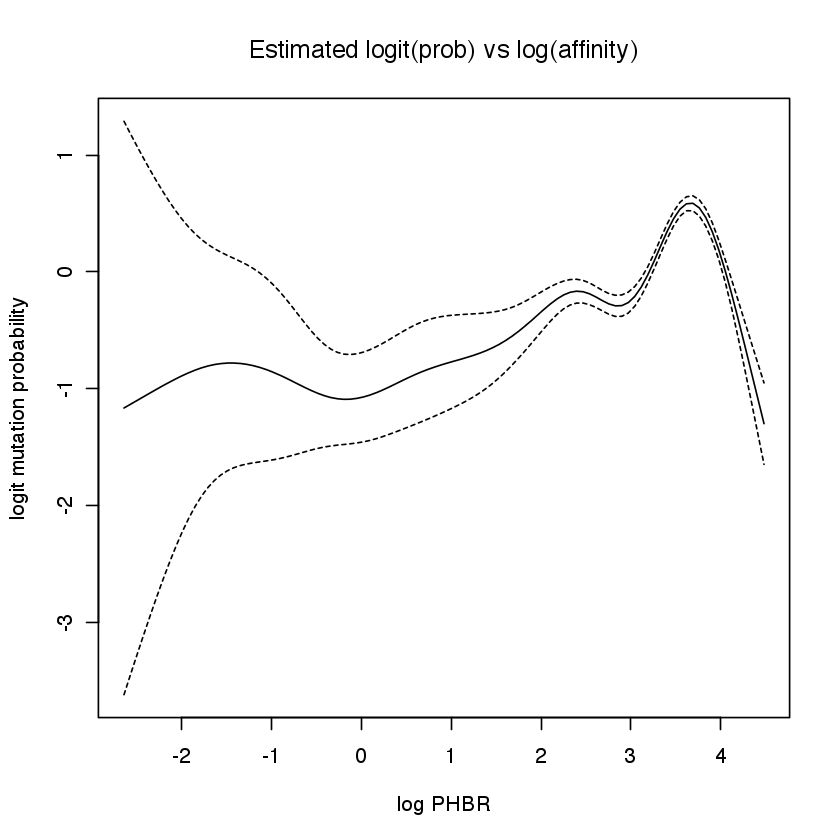

In [8]:
# threshold: 20
gam1= gam(y[sel] ~ s(log(z[sel])), family='binomial')
plot(gam1,rug=FALSE,xlab='log PHBR',ylab='logit mutation probability',main='Estimated logit(prob) vs log(affinity)')

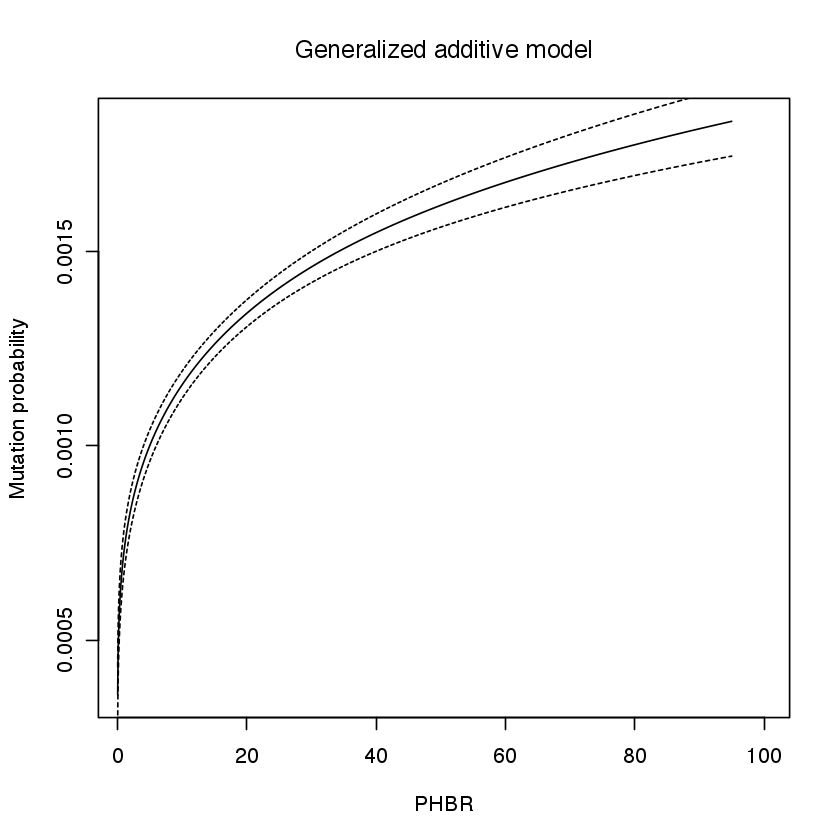

In [17]:
# threshold: 2
gam1= gam(y[sel] ~ s(log(z[sel])), family='binomial')
ypred= predict(gam1,type='response',se.fit=TRUE)
o= order(z[sel])
plot(z[sel][o],ypred$fit[o],type='l',xlim=c(1,100),xlab='PHBR',ylab='Mutation probability',main='Generalized additive model')
lines(z[sel][o],ypred$fit[o]-1.96*ypred$se.fit[o],lty=2)
lines(z[sel][o],ypred$fit[o]+1.96*ypred$se.fit[o],lty=2)

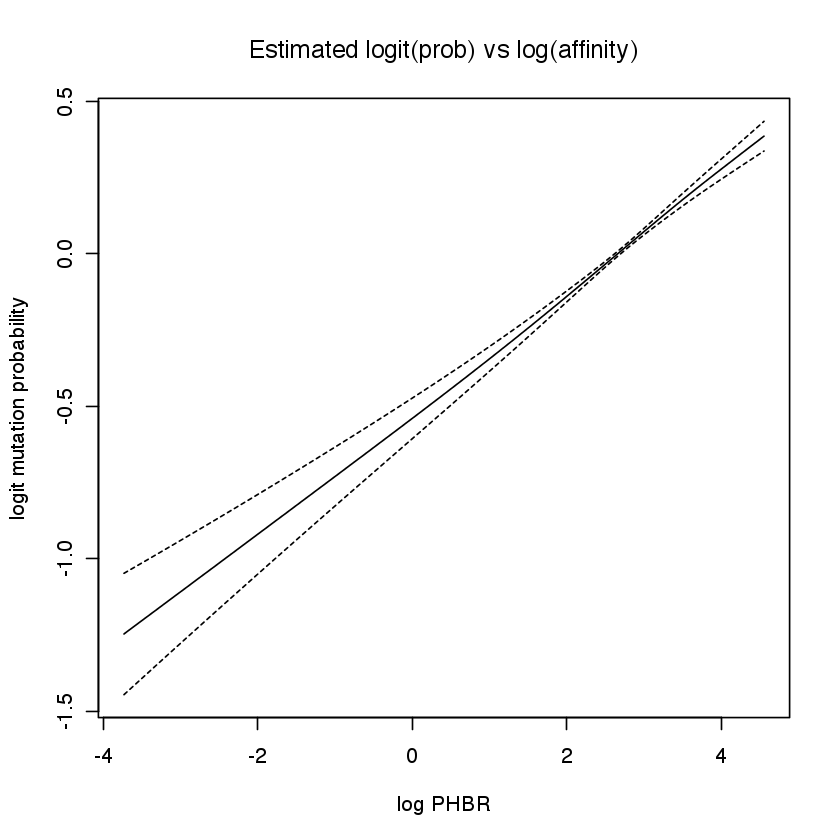

In [19]:
plot(gam1,rug=FALSE,xlab='log PHBR',ylab='logit mutation probability',main='Estimated logit(prob) vs log(affinity)')

Only MHC-I

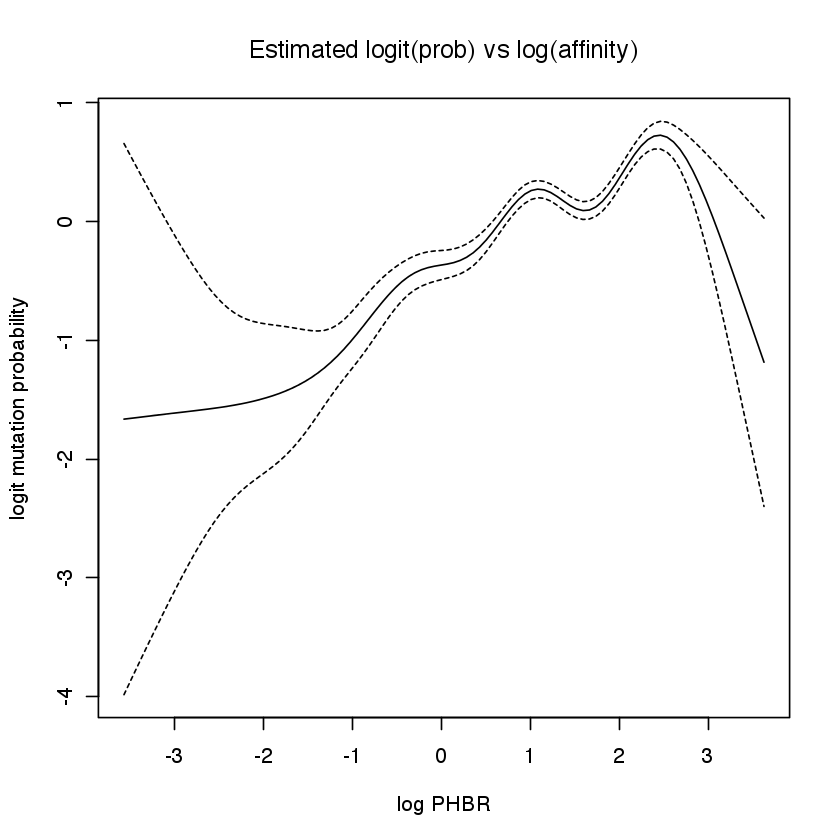

In [9]:
# threshold: 20
gam1= gam(y[sel] ~ s(log(x[sel])), family='binomial')
plot(gam1,rug=FALSE,xlab='log PHBR',ylab='logit mutation probability',main='Estimated logit(prob) vs log(affinity)')

In [ ]:
gam1= gam(y[sel] ~ s(log(x[sel])), family='binomial')
ypred= predict(gam1,type='response',se.fit=TRUE)
o= order(z[sel])
plot(z[sel][o],ypred$fit[o],type='l',xlim=c(1,100),xlab='MHC-I: PHBR',ylab='Mutation probability',main='Generalized additive model')
lines(z[sel][o],ypred$fit[o]-1.96*ypred$se.fit[o],lty=2)
lines(z[sel][o],ypred$fit[o]+1.96*ypred$se.fit[o],lty=2)

In [ ]:
plot(gam1,rug=FALSE,xlab='log MHC-I:PHBR',ylab='logit mutation probability',main='Estimated logit(prob) vs log(affinity)')

Combining both classes into a single model

In [ ]:
gam_interact= gam(y[sel] ~ s(log(x[sel]), log(z[sel])), family='binomial')

In [21]:
pdf('../../../generated_figures/matched_models/interactions/log.interaction_model.surface.pdf')
plot(gam_interact, all.terms=TRUE, scheme=1, ylim=c(0,4.5), xlim=c(-2,2),
     xlab='Log(MHC-I PHBR)',ylab='Log(MHC-II PHBR)', main='Mutation Probability')
dev.off()
pdf('../../../generated_figures/matched_models/interactions/log.interaction_model.heatmap_with_points.pdf')
plot(gam_interact, all.terms=TRUE, scheme=c(2,1), ylim=c(0,4.5), xlim=c(-2,2),
     xlab='Log(MHC-I PHBR)',ylab='Log(MHC-II PHBR)', main='Mutation Probability')
dev.off()
pdf('../../../generated_figures/matched_models/interactions/log.interaction_model.heatmap.pdf')
plot(gam_interact, rug=FALSE, all.terms=TRUE, scheme=c(2,1), ylim=c(0,4.5), xlim=c(-2,2),
     xlab='Log(MHC-I PHBR)',ylab='Log(MHC-II PHBR)', main='Mutation Probability')
dev.off()

pdf 
  2

Warning message in plot.gam(gam_interact, all.terms = TRUE, scheme = c(2, 1), ylim = c(0, :
“scheme should be a single number, or a vector with 1 elements”

pdf 
  2

Warning message in plot.gam(gam_interact, rug = FALSE, all.terms = TRUE, scheme = c(2, :
“scheme should be a single number, or a vector with 1 elements”

pdf 
  2

In [ ]:
plot(gam_interact, all.terms=TRUE, scheme=1, ylim=c(0,4), xlim=c(-2,2),
     xlab='Log(MHC-I PHBR)',ylab='Log(MHC-II PHBR)', main='Mutation Probability')

In [ ]:
plot(gam_interact, all.terms=TRUE, rug=FALSE, scheme=c(2,1), ylim=c(0,4), xlim=c(-2,2),
     xlab='Log(MHC-I PHBR)',ylab='Log(MHC-II PHBR)', main='Mutation Probability')

In [ ]:
plot(gam_interact, all.terms=TRUE, rug=FALSE, scheme=c(2,1),
     xlab='Log(MHC-I PHBR)',ylab='Log(MHC-II PHBR)', main='Mutation Probability')

In [ ]:
plot(gam_interact, all.terms=TRUE,  scheme=c(2,1),
     xlab='Log(MHC-I PHBR)',ylab='Log(MHC-II PHBR)', main='Mutation Probability')

In [14]:
# non log gam
gam_interact_nonlog= gam(y[sel] ~ s(x[sel], z[sel]), family='binomial')

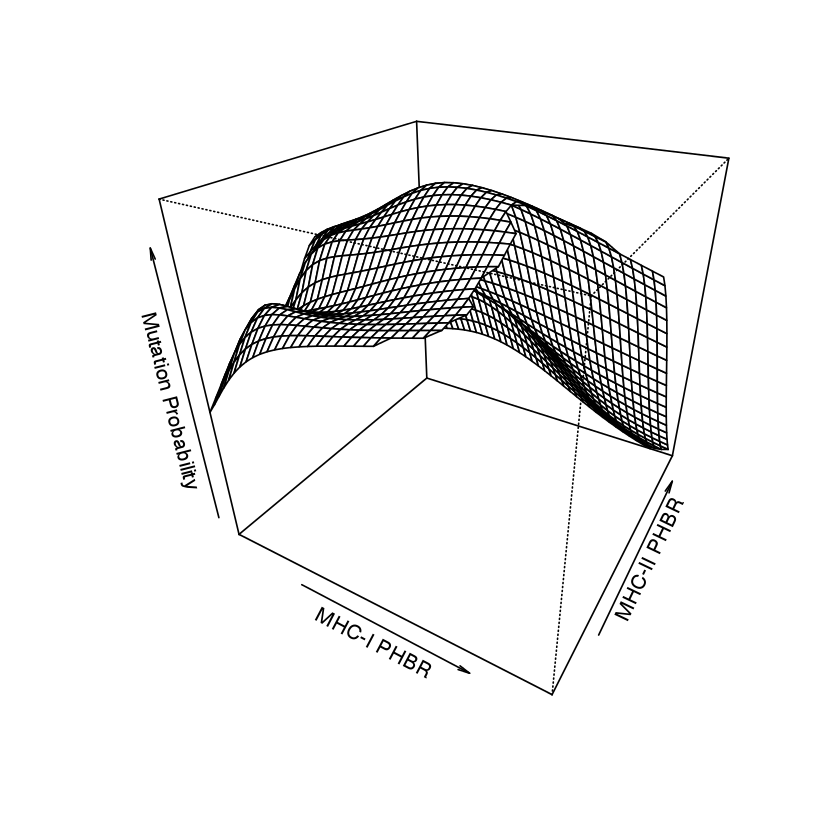

In [18]:
plot(gam_interact_nonlog, all.terms=TRUE, scheme=1, 
     xlab='MHC-I PHBR',ylab='MHC-II PHBR', main='Mutation Probability')

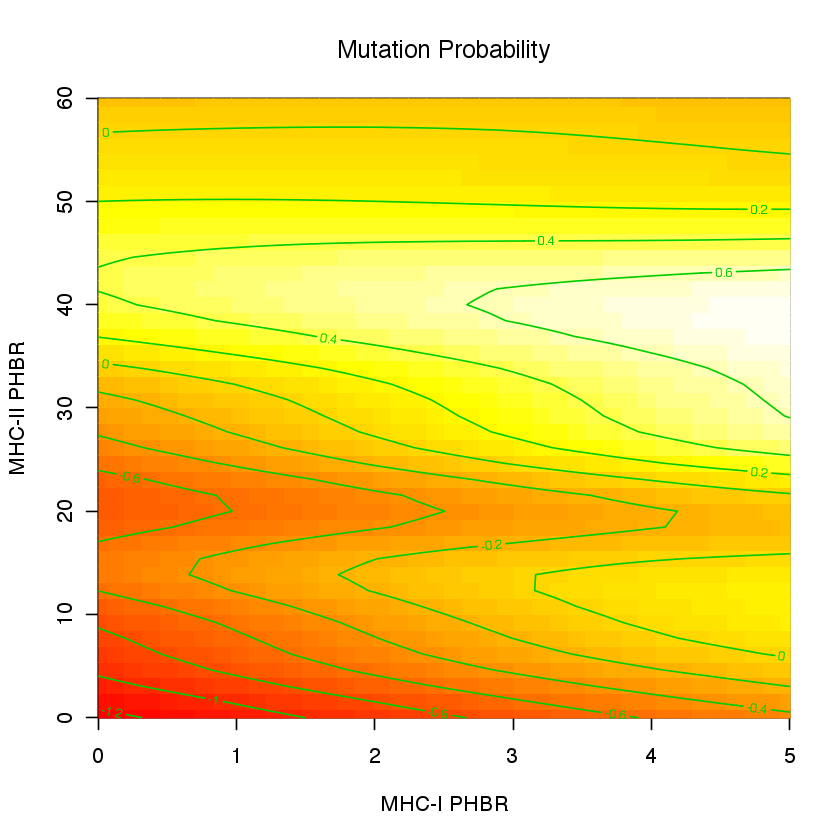

In [17]:
plot(gam_interact_nonlog, rug=FALSE, se=TRUE, scheme=2, ylim=c(0,60), xlim=c(0,5),
     xlab='MHC-I PHBR',ylab='MHC-II PHBR', main='Mutation Probability')

In [24]:
pdf('../../../generated_figures/matched_models/interactions/interaction_model.surface.pdf')
plot(gam_interact_nonlog, all.terms=TRUE, scheme=1, ylim=c(0,60), xlim=c(0,5),
     xlab='MHC-I PHBR',ylab='MHC-II PHBR', main='Mutation Probability')
dev.off()
pdf('../../../generated_figures/matched_models/interactions/interaction_model.heatmap_with_points.pdf')
plot(gam_interact_nonlog, all.terms=TRUE, scheme=c(2,1), ylim=c(0,60), xlim=c(0,5),
     xlab='MHC-I PHBR',ylab='MHC-II PHBR', main='Mutation Probability')
dev.off()
pdf('../../../generated_figures/matched_models/interactions/interaction_model.heatmap.pdf')
plot(gam_interact_nonlog, rug=FALSE, se=TRUE, scheme=2, ylim=c(0,60), xlim=c(0,5),
     xlab='MHC-I PHBR',ylab='MHC-II PHBR', main='Mutation Probability')
dev.off()

pdf 
  2

Warning message in plot.gam(gam_interact_nonlog, all.terms = TRUE, scheme = c(2, :
“scheme should be a single number, or a vector with 1 elements”

pdf 
  2

pdf 
  2

In [25]:
# whole space, not just concentrated
pdf('../../../generated_figures/matched_models/interactions/interaction_model.surface.whole.pdf')
plot(gam_interact_nonlog, all.terms=TRUE, scheme=1,
     xlab='MHC-I PHBR',ylab='MHC-II PHBR', main='Mutation Probability')
dev.off()
pdf('../../../generated_figures/matched_models/interactions/interaction_model.heatmap_with_points.whole.pdf')
plot(gam_interact_nonlog, all.terms=TRUE, scheme=c(2,1),
     xlab='MHC-I PHBR',ylab='MHC-II PHBR', main='Mutation Probability')
dev.off()
pdf('../../../generated_figures/matched_models/interactions/interaction_model.heatmap.whole.pdf')
plot(gam_interact_nonlog, rug=FALSE, se=TRUE, scheme=2,
     xlab='MHC-I PHBR',ylab='MHC-II PHBR', main='Mutation Probability')
dev.off()

pdf 
  2

Warning message in plot.gam(gam_interact_nonlog, all.terms = TRUE, scheme = c(2, :
“scheme should be a single number, or a vector with 1 elements”

pdf 
  2

pdf 
  2

In [26]:
gam_interact_ilog= gam(y[sel] ~ s(log(x[sel]), z[sel]), family='binomial')

In [27]:
pdf('../../../generated_figures/matched_models/interactions/ilog.interaction_model.surface.pdf')
plot(gam_interact_ilog, all.terms=TRUE, scheme=1, ylim=c(0,60), xlim=c(-2,2),
     xlab='Log(MHC-I PHBR)',ylab='Log(MHC-II PHBR)', main='Mutation Probability')
dev.off()
pdf('../../../generated_figures/matched_models/interactions/ilog.interaction_model.heatmap_with_points.pdf')
plot(gam_interact_ilog, all.terms=TRUE, scheme=c(2,1), ylim=c(0,60), xlim=c(-2,2),
     xlab='Log(MHC-I PHBR)',ylab='Log(MHC-II PHBR)', main='Mutation Probability')
dev.off()
pdf('../../../generated_figures/matched_models/interactions/ilog.interaction_model.heatmap.pdf')
plot(gam_interact_ilog, rug=FALSE, all.terms=TRUE, scheme=c(2,1), ylim=c(0,60), xlim=c(-2,2),
     xlab='Log(MHC-I PHBR)',ylab='Log(MHC-II PHBR)', main='Mutation Probability')
dev.off()

pdf 
  2

Warning message in plot.gam(gam_interact_ilog, all.terms = TRUE, scheme = c(2, 1), :
“scheme should be a single number, or a vector with 1 elements”

pdf 
  2

Warning message in plot.gam(gam_interact_ilog, rug = FALSE, all.terms = TRUE, scheme = c(2, :
“scheme should be a single number, or a vector with 1 elements”

pdf 
  2

Random effects model

In [56]:
# neither logged
lme_combined= glmer(y[sel] ~ z[sel] + x[sel] + (1|pat[sel]), family='binomial')
summary(lme_combined)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y[sel] ~ z[sel] + x[sel] + (1 | pat[sel])

     AIC      BIC   logLik deviance df.resid 
 33244.0  33289.8 -16618.0  33236.0   696791 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.1414 -0.0627 -0.0584 -0.0551 19.2567 

Random effects:
 Groups   Name        Variance Std.Dev.
 pat[sel] (Intercept) 1e-12    1e-06   
Number of obs: 696795, groups:  pat[sel], 4223

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.9177132  0.0346628 -170.72  < 2e-16 ***
z[sel]       0.0062108  0.0008621    7.20 5.85e-13 ***
x[sel]       0.0288512  0.0042825    6.74 1.62e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
       (Intr) z[sel]
z[sel] -0.670       
x[sel] -0.217 -0.335
convergence code: 0
Model is nearly unidentifiable: very large eigenvalue
 - Rescale varia

In [127]:
# both logged
lme_combined_both_logged= glmer(y[sel] ~ log(z[sel]) + log(x[sel]) + (1|pat[sel]), family='binomial')
summary(lme_combined_both_logged)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y[sel] ~ log(z[sel]) + log(x[sel]) + (1 | pat[sel])

     AIC      BIC   logLik deviance df.resid 
 33034.7  33080.5 -16513.4  33026.7   696791 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.098 -0.067 -0.060 -0.052 41.507 

Random effects:
 Groups   Name        Variance Std.Dev.
 pat[sel] (Intercept) 0        0       
Number of obs: 696795, groups:  pat[sel], 4223

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.31899    0.06544  -96.56   <2e-16 ***
log(z[sel])  0.17165    0.02037    8.43   <2e-16 ***
log(x[sel])  0.22863    0.01856   12.32   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) lg(z[])
log(z[sel]) -0.916        
log(x[sel])  0.021 -0.293 

In [60]:
# class_i logged
lme_combined_I_logged= glmer(y[sel] ~ z[sel] + log(x[sel]) + (1|pat[sel]), family='binomial')
summary(lme_combined_I_logged)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y[sel] ~ z[sel] + log(x[sel]) + (1 | pat[sel])

     AIC      BIC   logLik deviance df.resid 
 33086.0  33131.8 -16539.0  33078.0   696791 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.1022 -0.0659 -0.0592 -0.0524 30.7106 

Random effects:
 Groups   Name        Variance  Std.Dev. 
 pat[sel] (Intercept) 6.419e-13 8.012e-07
Number of obs: 696795, groups:  pat[sel], 4223

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.9558779  0.0355964 -167.32  < 2e-16 ***
z[sel]       0.0046173  0.0008736    5.29 1.25e-07 ***
log(x[sel])  0.2502009  0.0184708   13.55  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) z[sel]
z[sel]      -0.679       
log(x[sel]) -0.252 -0.295
convergence code: 0
Model is nearly unidentifiable: very large eig

In [61]:
# class_ii logged
lme_combined_II_logged= glmer(y[sel] ~ log(z[sel]) + x[sel] + (1|pat[sel]), family='binomial')
summary(lme_combined_II_logged)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y[sel] ~ log(z[sel]) + x[sel] + (1 | pat[sel])

     AIC      BIC   logLik deviance df.resid 
 33163.7  33209.5 -16577.8  33155.7   696791 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.128 -0.065 -0.060 -0.055 33.751 

Random effects:
 Groups   Name        Variance  Std.Dev. 
 pat[sel] (Intercept) 1.371e-13 3.703e-07
Number of obs: 696795, groups:  pat[sel], 4223

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.374483   0.065554  -97.24  < 2e-16 ***
log(z[sel])  0.216865   0.020244   10.71  < 2e-16 ***
x[sel]       0.025804   0.004284    6.02 1.71e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) lg([])
log(z[sel]) -0.918       
x[sel]       0.000 -0.266

Figure out predictive power with cross validation

In [128]:
# lme_combined_both_logged= glmer(y[sel] ~ log(z[sel]) + log(x[sel]) + (1|pat[sel]), family='binomial')
lme_combined_both_logged

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y[sel] ~ log(z[sel]) + log(x[sel]) + (1 | pat[sel])
      AIC       BIC    logLik  deviance  df.resid 
 33034.71  33080.53 -16513.36  33026.71    696791 
Random effects:
 Groups   Name        Std.Dev.
 pat[sel] (Intercept) 0       
Number of obs: 696795, groups:  pat[sel], 4223
Fixed Effects:
(Intercept)  log(z[sel])  log(x[sel])  
    -6.3190       0.1717       0.2286  

In [177]:
lme_combined_both_logged2= glmer(y_ ~ log(z_) + log(x_) + (1|pat_), data=df, family='binomial')

In [178]:
summary(lme_combined_both_logged2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y_ ~ log(z_) + log(x_) + (1 | pat_)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 33034.7  33080.5 -16513.4  33026.7   696791 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.098 -0.067 -0.060 -0.052 41.507 

Random effects:
 Groups Name        Variance Std.Dev.
 pat_   (Intercept) 0        0       
Number of obs: 696795, groups:  pat_, 4223

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.31899    0.06544  -96.56   <2e-16 ***
log(z_)      0.17165    0.02037    8.43   <2e-16 ***
log(x_)      0.22863    0.01856   12.32   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr) lg(z_)
log(z_) -0.916       
log(x_)  0.021 -0.293

In [203]:
round(nrow(df)/10)

[1] 69680

In [13]:
library('AUC')

AUC 0.3.0
Type AUCNews() to see the change log and ?AUC to get an overview.


In [12]:
df = data.frame(y[sel], x[sel], z[sel], pat[sel])
colnames(df)<-c('y', 'x', 'z', 'pat')

[1] 1
[1] 2
[1] 3
[1] 0.5007454


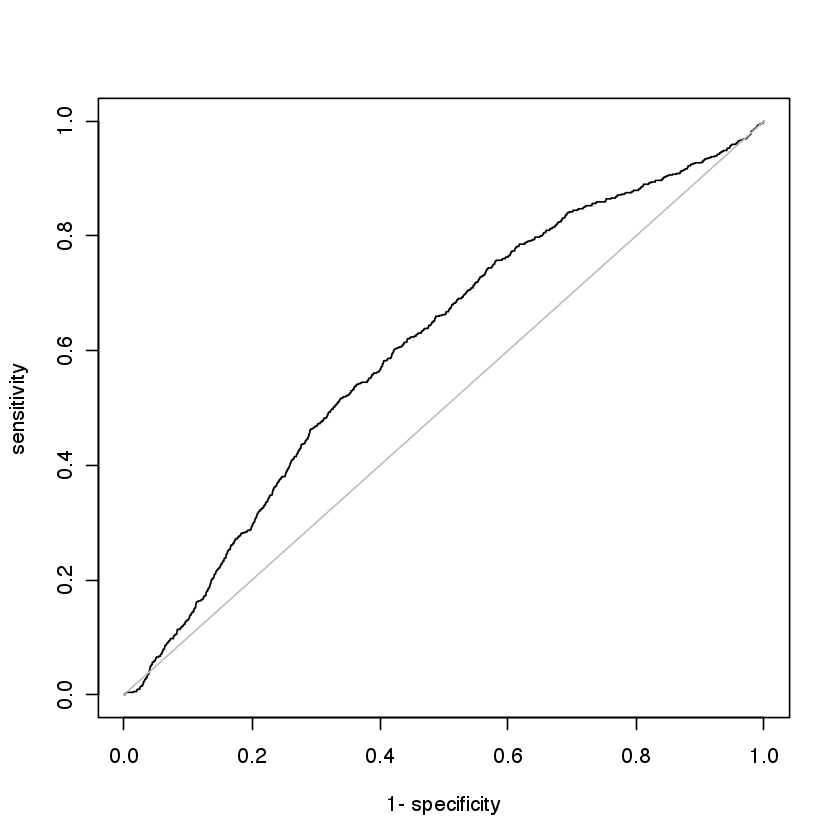

In [8]:
# both MHC-I and MHC-II
all_labels=NULL
all_predictions=NULL
for (i in 1:3)
{
    print(i)
    # sample indices
    sample_rows = sample(nrow(df), round(nrow(df)/10))
    # to test the model
    DataC1=df[sample_rows, ]
    # to train the model
    DataCV=df[-sample_rows, ]
    # train the model
    M1 <- glmer(y ~ log(z) + log(x) + (1|pat), data=DataCV, family='binomial')
    # predict mutation probabilities
    P1=predict(M1, DataC1)
    names(P1)=NULL
    all_predictions= c(all_predictions, P1)
    all_labels = c(all_labels, DataC1$y)
}
# put in dataframe and transform
results_df = data.frame(all_labels, all_predictions)
colnames(results_df)<-c('label', 'predicted')
# probabilities
results_df$predicted_prob<-exp(results_df$predicted)
# labels as factors
results_df$label_fact <- factor(results_df$label)

acc<-accuracy(results_df$predicted_prob, results_df$label_fact)
print(auc(acc, min=0, max=1))
plot(roc(results_df$predicted_prob, results_df$label_fact))

[1] 1
[1] 2
[1] 3
[1] 0.5006607


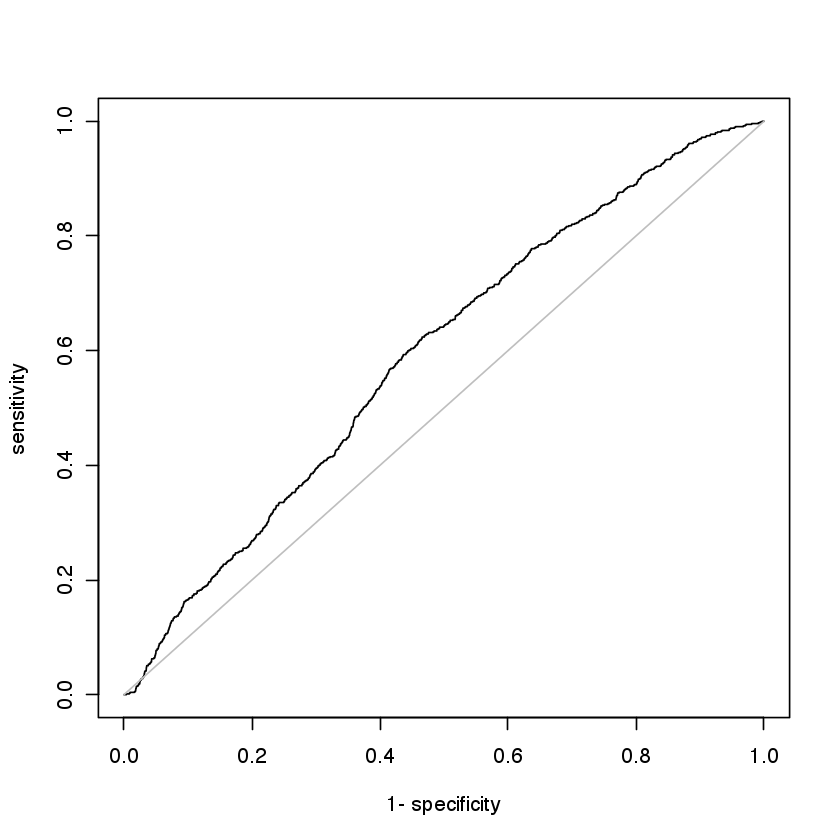

In [9]:
# only MHC-I
all_labels=NULL
all_predictions=NULL
for (i in 1:3)
{
    print(i)
    # sample indices
    sample_rows = sample(nrow(df), round(nrow(df)/10))
    # to test the model
    DataC1=df[sample_rows, ]
    # to train the model
    DataCV=df[-sample_rows, ]
    # train the model
    M1 <- glmer(y ~ log(x) + (1|pat), data=DataCV, family='binomial')
    # predict mutation probabilities
    P1=predict(M1, DataC1)
    names(P1)=NULL
    all_predictions= c(all_predictions, P1)
    all_labels = c(all_labels, DataC1$y)
}
# put in dataframe and transform
results_dfI = data.frame(all_labels, all_predictions)
colnames(results_dfI)<-c('label', 'predicted')
# probabilities
results_dfI$predicted_prob<-exp(results_dfI$predicted)
# labels as factors
results_dfI$label_fact <- factor(results_dfI$label)

acc<-accuracy(results_dfI$predicted_prob, results_dfI$label_fact)
print(auc(acc, min=0, max=1))
plot(roc(results_dfI$predicted_prob, results_dfI$label_fact))

[1] 1
[1] 2
[1] 3
[1] 0.5003502


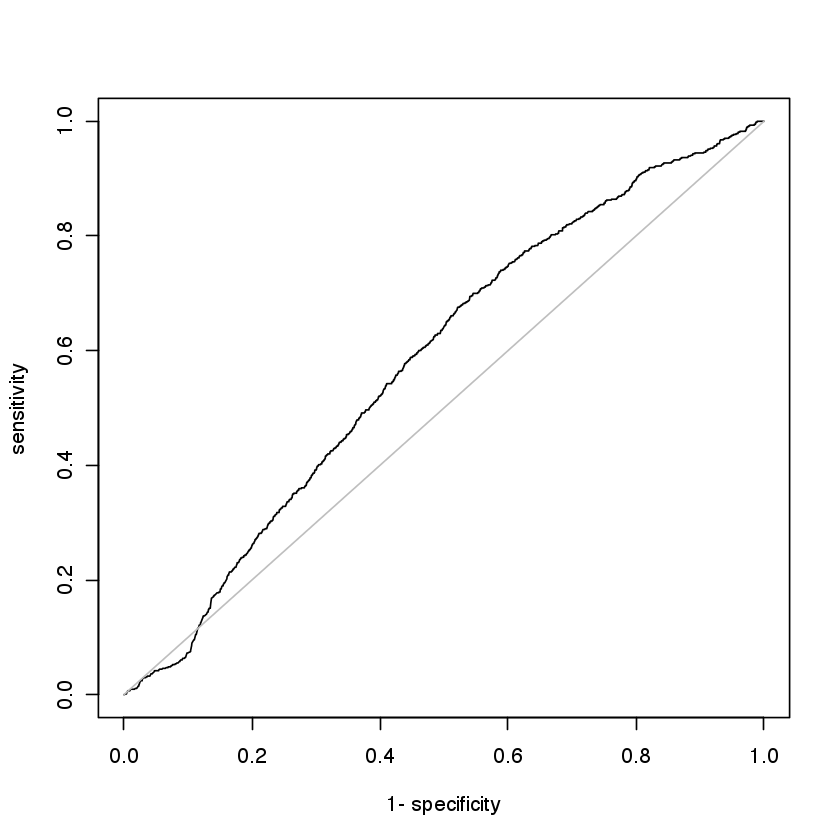

In [10]:
# only MHC-II
all_labels=NULL
all_predictions=NULL
for (i in 1:3)
{
    print(i)
    # sample indices
    sample_rows = sample(nrow(df), round(nrow(df)/10))
    # to test the model
    DataC1=df[sample_rows, ]
    # to train the model
    DataCV=df[-sample_rows, ]
    # train the model
    M1 <- glmer(y ~ log(z) + (1|pat), data=DataCV, family='binomial')
    # predict mutation probabilities
    P1=predict(M1, DataC1)
    names(P1)=NULL
    all_predictions= c(all_predictions, P1)
    all_labels = c(all_labels, DataC1$y)
}
# put in dataframe and transform
results_dfII = data.frame(all_labels, all_predictions)
colnames(results_dfII)<-c('label', 'predicted')
# probabilities
results_dfII$predicted_prob<-exp(results_dfII$predicted)
# labels as factors
results_dfII$label_fact <- factor(results_dfII$label)

acc<-accuracy(results_dfII$predicted_prob, results_dfII$label_fact)
print(auc(acc, min=0, max=1))
plot(roc(results_dfII$predicted_prob, results_dfII$label_fact))

[1] 1


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00621618 (tol = 0.001, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”

[1] 2


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”

[1] 3


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00921977 (tol = 0.001, component 1)”Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”

[1] 0.5001995


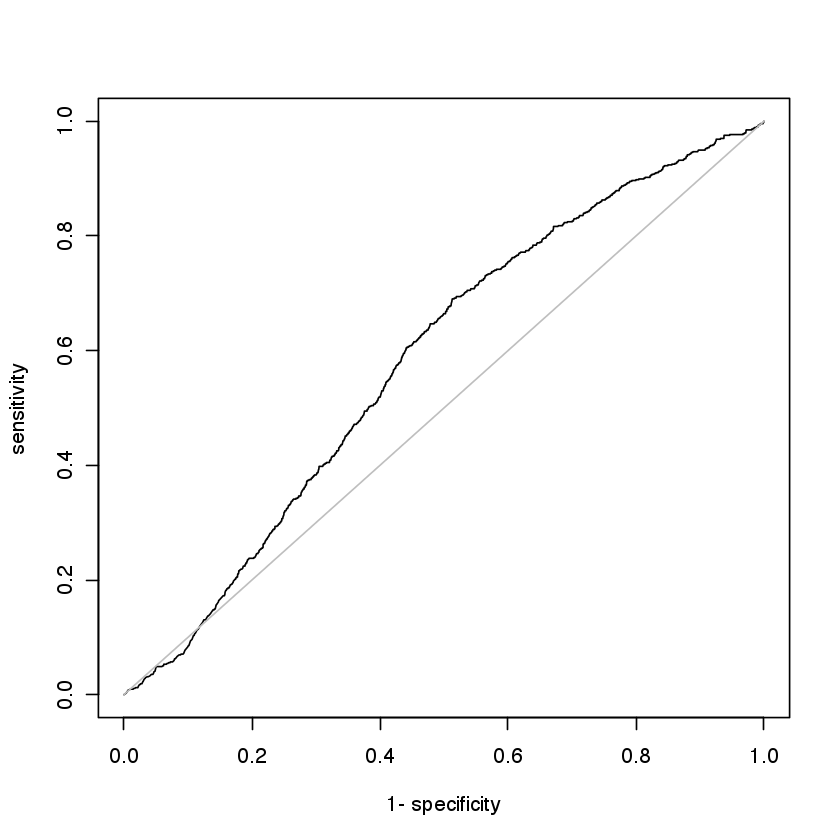

In [11]:
# only MHC-II, non-log
all_labels=NULL
all_predictions=NULL
for (i in 1:3)
{
    print(i)
    # sample indices
    sample_rows = sample(nrow(df), round(nrow(df)/10))
    # to test the model
    DataC1=df[sample_rows, ]
    # to train the model
    DataCV=df[-sample_rows, ]
    # train the model
    M1 <- glmer(y ~ z + (1|pat), data=DataCV, family='binomial')
    # predict mutation probabilities
    P1=predict(M1, DataC1)
    names(P1)=NULL
    all_predictions= c(all_predictions, P1)
    all_labels = c(all_labels, DataC1$y)
}
# put in dataframe and transform
results_dfIInl = data.frame(all_labels, all_predictions)
colnames(results_dfIInl)<-c('label', 'predicted')
# probabilities
results_dfIInl$predicted_prob<-exp(results_dfIInl$predicted)
# labels as factors
results_dfIInl$label_fact <- factor(results_dfIInl$label)

acc<-accuracy(results_dfIInl$predicted_prob, results_dfIInl$label_fact)
print(auc(acc, min=0, max=1))
plot(roc(results_dfIInl$predicted_prob, results_dfIInl$label_fact))

In [12]:
library(pROC)
roc_obj <- roc(results_df$label_fact, results_df$predicted_prob)
auc(roc_obj)

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:AUC’:

    auc, roc

The following objects are masked from ‘package:stats’:

    cov, smooth, var



Area under the curve: 0.6054

In [13]:
library(pROC)
roc_obj <- roc(results_dfI$label_fact, results_dfI$predicted_prob)
auc(roc_obj)

Area under the curve: 0.5929

In [14]:
library(pROC)
roc_obj <- roc(results_dfII$label_fact, results_dfII$predicted_prob)
auc(roc_obj)

Area under the curve: 0.5827

In [15]:
library(pROC)
roc_obj <- roc(results_dfIInl$label_fact, results_dfIInl$predicted_prob)
auc(roc_obj)

Area under the curve: 0.584

Small toy examples to move to scripts

In [15]:
sampled_pats = head(unique(df$pat), 100)

In [16]:
sampled_df = df[df[, "pat"] %in% sampled_pats,]

In [17]:
nrow(sampled_df)

[1] 29000

In [18]:
# both MHC-I and MHC-II
all_labels=NULL
all_predictions=NULL
for (i in 1:2)
{
    print(i)
    # sample indices
    sample_rows = sample(nrow(sampled_df), round(nrow(sampled_df)/10))
    # to test the model
    DataC1=sampled_df[sample_rows, ]
    # to train the model
    DataCV=sampled_df[-sample_rows, ]
    # train the model
    M1 <- glmer(y ~ log(z) + log(x) + (1|pat), data=DataCV, family='binomial')
    # predict mutation probabilities
    P1=predict(M1, DataC1)
    names(P1)=NULL
    all_predictions= c(all_predictions, P1)
    all_labels = c(all_labels, DataC1$y)
}
# put in dataframe and transform
results_df = data.frame(all_labels, all_predictions)
colnames(results_df)<-c('label', 'predicted')
# probabilities
results_df$predicted_prob<-exp(results_df$predicted)
# labels as factors
results_df$label_fact <- factor(results_df$label)

#acc<-accuracy(results_df$predicted_prob, results_df$label_fact)
#print(auc(acc, min=0, max=1))
#plot(roc(results_df$predicted_prob, results_df$label_fact))

[1] 1
[1] 2


In [19]:
write.table(results_df, file='../../../generated_data/prediction_table.csv')